# SELF DRIVING CAR 

<img src='selfdrivingcar.jpg'/>

In [ ]:
import tensorflow as tf
import cv2
from subprocess import call
import math
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model
import tensorflow as tf
import scipy
import scipy.misc
import random
import numpy as np
from scipy import pi
from itertools import islice
from __future__ import division
import os
os.chdir('C:/Users/kingsubham27091995/Desktop/AppliedAiCouse/CASE STUDIES/Self Driving Car/Autopilot-TensorFlow-master/Autopilot-TensorFlow-master')


## Performing EDA

In [34]:
# read images and steering angles from driving_dataset folder
DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.8 #This is giving the 80% Train and 20% Test Data Split
X = []
y = []
with open(TRAIN_FILE) as fp: #Reading tre file
    for line in islice(fp,None):
        path, angle = line.strip().split()  #Reading the path and angle
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

# Now split the angles into train_y and test_y
split_index = int(len(y)*0.8)

train_y = y[:split_index] #First 80%
test_y = y[split_index:] # Last 20%

          

Completed processing data.txt


C:\Users\kingsubham27091995\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


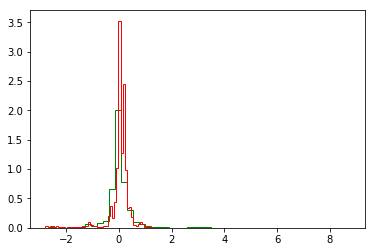

In [35]:
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()




## Observation:

__1. The steering angles do not completely overlap which means that there is difference in train and test data in steering angles.__

__2. Most often the steering angle is zero degrees(driving staright)__

__3. Most of the steering angle lies between {-2,+2}__

## Loading the data

In [ ]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        #We split the text data(data.txt file) and line.split()[0] will give inage name , line.split()[1] gives angles
        xs.append("driving_dataset/" + line.split()[0]) #xs contains the path to the images.
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180) #ys contains the angles in radians

#get number of images
num_images = len(xs)

## 70:30 Train-Test Split

In [4]:

#Temporal split
train_xs = xs[:int(len(xs) * 0.7)] 
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)


## Creating batches of data for Train and Test

In [ ]:
# This function loads batch of images from training data
def LoadTrainBatch(batch_size): #batch_size will give the number of images in each batch we want to pass
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        # We will take the last 150 images where road is present
        '''We are cropping the image to get only the lower part we analyzed the images
        and we think like if we crop the image, we will get only road part of the image
        and it will be useful to drive'''
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

# This function loads batch of images from test data
def LoadValBatch(batch_size):
    global val_batch_pointer #Take this global so that it remembers the pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

# Defining NVIDIA's End to End CNN architecture

In [29]:

def weight_variable(shape):  
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3]) # For Input variables
y_ = tf.placeholder(tf.float32, shape=[None, 1]) 

x_image = x #Image dimension

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24]) # (5*5) kernels, 24 kernels
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36]) # (5*5) kernels, 36 kernels
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48]) # (5*5) kernels, 48 kernels
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64]) # (3*3) kernels, 64 kernels
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64]) # (3*3) kernels, 64 kernels
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152]) # Flatten
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)  
#y = tf.multipltf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) 

# atan works better than 'linear' here.

# Training

In [30]:


LOGDIR = './save_assignment2'

sess = tf.InteractiveSession()

L2NormConst = 0.001 # Lambda of L2-Regularisation

train_vars = tf.trainable_variables()

#!st Part is the Loss(MeanSquaredError or Reduced_mean)
#2nd part is the Regularisation part
loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss) #Learning Rate Default =10^-3
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5}) #keep_prob=0.5 means , dropout=0.5
        #After every 10 steps we will print the Epochs and Loss
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


C:\Users\kingsubham27091995\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0, Step: 0, Loss: 62.141
Epoch: 0, Step: 10, Loss: 60.868
Epoch: 0, Step: 20, Loss: 59.8293
Epoch: 0, Step: 30, Loss: 58.8119
Epoch: 0, Step: 40, Loss: 57.5123
Epoch: 0, Step: 50, Loss: 56.4577
Epoch: 0, Step: 60, Loss: 55.4984
Epoch: 0, Step: 70, Loss: 54.6252
Epoch: 0, Step: 80, Loss: 54.0038
Epoch: 0, Step: 90, Loss: 54.4305
Epoch: 0, Step: 100, Loss: 52.9877
Epoch: 0, Step: 110, Loss: 50.9059
Epoch: 0, Step: 120, Loss: 50.024
Epoch: 0, Step: 130, Loss: 49.1687
Epoch: 0, Step: 140, Loss: 48.3397
Epoch: 0, Step: 150, Loss: 47.5021
Epoch: 0, Step: 160, Loss: 46.7609
Epoch: 0, Step: 170, Loss: 46.0305
Epoch: 0, Step: 180, Loss: 45.1239
Epoch: 0, Step: 190, Loss: 44.3693
Epoch: 0, Step: 200, Loss: 43.6895
Epoch: 0, Step: 210, Loss: 43.1158
Epoch: 0, Step: 220, Loss: 42.2329
Epoch: 0, Step: 230, Loss: 41.4071
Epoch: 0, Step: 240, Loss: 40.7029
Epoch: 0, Step: 250, Loss: 40.0164
Epoch: 0, Step: 260, Loss: 39.3414
Epoch: 0, Step: 270, Loss: 38.6786
Epoch: 0, Step: 280, Loss: 38.9137

Epoch: 2, Step: 310, Loss: 11.1804
Epoch: 2, Step: 320, Loss: 11.0114
Epoch: 2, Step: 330, Loss: 10.8303
Epoch: 2, Step: 340, Loss: 10.6549
Epoch: 2, Step: 350, Loss: 10.5534
Epoch: 2, Step: 360, Loss: 10.4222
Epoch: 2, Step: 370, Loss: 10.1571
Epoch: 2, Step: 380, Loss: 10.0304
Epoch: 2, Step: 390, Loss: 9.95195
Epoch: 2, Step: 400, Loss: 9.94301
Epoch: 2, Step: 410, Loss: 9.66138
Epoch: 2, Step: 420, Loss: 9.36528
Epoch: 2, Step: 430, Loss: 9.21705
Epoch: 2, Step: 440, Loss: 9.07277
Epoch: 2, Step: 450, Loss: 8.93077
Epoch: 2, Step: 460, Loss: 8.79281
Epoch: 2, Step: 470, Loss: 10.751
Epoch: 2, Step: 480, Loss: 12.3616
Epoch: 2, Step: 490, Loss: 8.39923
Epoch: 2, Step: 500, Loss: 8.26345
Epoch: 2, Step: 510, Loss: 8.13181
Epoch: 2, Step: 520, Loss: 8.00452
Epoch: 2, Step: 530, Loss: 7.88729
Epoch: 2, Step: 540, Loss: 7.769
Epoch: 2, Step: 550, Loss: 7.65708
Epoch: 2, Step: 560, Loss: 7.5424
Epoch: 2, Step: 570, Loss: 7.42822
Epoch: 2, Step: 580, Loss: 7.31018
Epoch: 2, Step: 590, Los

Epoch: 4, Step: 610, Loss: 2.71942
Epoch: 4, Step: 620, Loss: 2.68959
Epoch: 4, Step: 630, Loss: 2.66085
Epoch: 4, Step: 640, Loss: 2.63216
Epoch: 4, Step: 650, Loss: 2.60743
Epoch: 4, Step: 660, Loss: 6.2063
Epoch: 4, Step: 670, Loss: 4.82151
Epoch: 4, Step: 680, Loss: 2.52865
Epoch: 4, Step: 690, Loss: 2.50116
Epoch: 4, Step: 700, Loss: 2.47185
Epoch: 4, Step: 710, Loss: 2.44761
Epoch: 4, Step: 720, Loss: 2.42509
Epoch: 4, Step: 730, Loss: 2.40754
Epoch: 4, Step: 740, Loss: 2.38006
Epoch: 4, Step: 750, Loss: 2.35861
Epoch: 4, Step: 760, Loss: 2.33343
Epoch: 4, Step: 770, Loss: 2.30817
Epoch: 4, Step: 780, Loss: 2.29064
Epoch: 4, Step: 790, Loss: 2.28043
Epoch: 4, Step: 800, Loss: 2.25426
Epoch: 4, Step: 810, Loss: 2.22287
Epoch: 4, Step: 820, Loss: 2.19647
Epoch: 4, Step: 830, Loss: 2.18121
Epoch: 4, Step: 840, Loss: 2.15787
Epoch: 4, Step: 850, Loss: 2.13493
Model saved in file: ./save_assignment2\model.ckpt
Epoch: 5, Step: 500, Loss: 2.13205
Epoch: 5, Step: 510, Loss: 2.10634
Epoch

Epoch: 6, Step: 910, Loss: 1.23594
Epoch: 6, Step: 920, Loss: 1.2411
Epoch: 6, Step: 930, Loss: 1.22583
Epoch: 6, Step: 940, Loss: 1.21995
Epoch: 6, Step: 950, Loss: 1.22335
Epoch: 6, Step: 960, Loss: 1.22883
Epoch: 6, Step: 970, Loss: 1.19776
Epoch: 6, Step: 980, Loss: 1.20284
Epoch: 6, Step: 990, Loss: 1.18903
Epoch: 6, Step: 1000, Loss: 1.18481
Epoch: 6, Step: 1010, Loss: 1.17148
Epoch: 6, Step: 1020, Loss: 1.18017
Epoch: 6, Step: 1030, Loss: 1.16745
Epoch: 6, Step: 1040, Loss: 1.15919
Epoch: 6, Step: 1050, Loss: 1.1627
Model saved in file: ./save_assignment2\model.ckpt
Epoch: 7, Step: 700, Loss: 1.15164
Epoch: 7, Step: 710, Loss: 1.14968
Epoch: 7, Step: 720, Loss: 1.14961
Epoch: 7, Step: 730, Loss: 1.13708
Epoch: 7, Step: 740, Loss: 1.12967
Epoch: 7, Step: 750, Loss: 1.12416
Epoch: 7, Step: 760, Loss: 1.11968
Epoch: 7, Step: 770, Loss: 1.11031
Epoch: 7, Step: 780, Loss: 1.10368
Epoch: 7, Step: 790, Loss: 1.15794
Epoch: 7, Step: 800, Loss: 1.48137
Epoch: 7, Step: 810, Loss: 6.50013


Epoch: 8, Step: 1210, Loss: 0.757493
Epoch: 8, Step: 1220, Loss: 0.751475
Epoch: 8, Step: 1230, Loss: 0.745227
Epoch: 8, Step: 1240, Loss: 0.747039
Epoch: 8, Step: 1250, Loss: 0.740273
Model saved in file: ./save_assignment2\model.ckpt
Epoch: 9, Step: 900, Loss: 0.749808
Epoch: 9, Step: 910, Loss: 0.749644
Epoch: 9, Step: 920, Loss: 0.749593
Epoch: 9, Step: 930, Loss: 0.73845
Epoch: 9, Step: 940, Loss: 0.737586
Epoch: 9, Step: 950, Loss: 0.724425
Epoch: 9, Step: 960, Loss: 0.725452
Epoch: 9, Step: 970, Loss: 0.737536
Epoch: 9, Step: 980, Loss: 0.823336
Epoch: 9, Step: 990, Loss: 2.59104
Epoch: 9, Step: 1000, Loss: 5.18455
Epoch: 9, Step: 1010, Loss: 0.796562
Epoch: 9, Step: 1020, Loss: 0.776624
Epoch: 9, Step: 1030, Loss: 0.707454
Epoch: 9, Step: 1040, Loss: 0.70275
Epoch: 9, Step: 1050, Loss: 0.703472
Epoch: 9, Step: 1060, Loss: 0.724911
Epoch: 9, Step: 1070, Loss: 0.857539
Epoch: 9, Step: 1080, Loss: 0.701774
Epoch: 9, Step: 1090, Loss: 0.697818
Epoch: 9, Step: 1100, Loss: 0.729215
E

Epoch: 11, Step: 1110, Loss: 0.520673
Epoch: 11, Step: 1120, Loss: 0.508643
Epoch: 11, Step: 1130, Loss: 0.498044
Epoch: 11, Step: 1140, Loss: 0.488218
Epoch: 11, Step: 1150, Loss: 0.489666
Epoch: 11, Step: 1160, Loss: 0.511554
Epoch: 11, Step: 1170, Loss: 0.550961
Epoch: 11, Step: 1180, Loss: 3.20372
Epoch: 11, Step: 1190, Loss: 3.18727
Epoch: 11, Step: 1200, Loss: 0.478843
Epoch: 11, Step: 1210, Loss: 0.475475
Epoch: 11, Step: 1220, Loss: 0.528121
Epoch: 11, Step: 1230, Loss: 0.53284
Epoch: 11, Step: 1240, Loss: 0.514925
Epoch: 11, Step: 1250, Loss: 0.519839
Epoch: 11, Step: 1260, Loss: 0.577766
Epoch: 11, Step: 1270, Loss: 0.465678
Epoch: 11, Step: 1280, Loss: 0.482748
Epoch: 11, Step: 1290, Loss: 0.478219
Epoch: 11, Step: 1300, Loss: 0.485534
Epoch: 11, Step: 1310, Loss: 0.459256
Epoch: 11, Step: 1320, Loss: 0.495284
Epoch: 11, Step: 1330, Loss: 0.476625
Epoch: 11, Step: 1340, Loss: 0.46535
Epoch: 11, Step: 1350, Loss: 0.456268
Epoch: 11, Step: 1360, Loss: 0.470384
Epoch: 11, Step:

Epoch: 13, Step: 1390, Loss: 0.385744
Epoch: 13, Step: 1400, Loss: 0.354768
Epoch: 13, Step: 1410, Loss: 0.34602
Epoch: 13, Step: 1420, Loss: 0.453759
Epoch: 13, Step: 1430, Loss: 0.354027
Epoch: 13, Step: 1440, Loss: 0.401362
Epoch: 13, Step: 1450, Loss: 0.491584
Epoch: 13, Step: 1460, Loss: 0.350041
Epoch: 13, Step: 1470, Loss: 0.412405
Epoch: 13, Step: 1480, Loss: 0.354694
Epoch: 13, Step: 1490, Loss: 0.352369
Epoch: 13, Step: 1500, Loss: 0.345523
Epoch: 13, Step: 1510, Loss: 0.383426
Epoch: 13, Step: 1520, Loss: 0.360479
Epoch: 13, Step: 1530, Loss: 0.422738
Epoch: 13, Step: 1540, Loss: 0.408629
Epoch: 13, Step: 1550, Loss: 0.35197
Epoch: 13, Step: 1560, Loss: 0.335974
Epoch: 13, Step: 1570, Loss: 0.339005
Epoch: 13, Step: 1580, Loss: 0.332908
Epoch: 13, Step: 1590, Loss: 0.330553
Epoch: 13, Step: 1600, Loss: 0.327765
Epoch: 13, Step: 1610, Loss: 0.326702
Epoch: 13, Step: 1620, Loss: 0.321676
Epoch: 13, Step: 1630, Loss: 0.327171
Epoch: 13, Step: 1640, Loss: 0.327691
Epoch: 13, Ste

Epoch: 15, Step: 1630, Loss: 0.349065
Epoch: 15, Step: 1640, Loss: 0.345277
Epoch: 15, Step: 1650, Loss: 0.266961
Epoch: 15, Step: 1660, Loss: 0.33816
Epoch: 15, Step: 1670, Loss: 0.267185
Epoch: 15, Step: 1680, Loss: 0.273094
Epoch: 15, Step: 1690, Loss: 0.263706
Epoch: 15, Step: 1700, Loss: 0.271179
Epoch: 15, Step: 1710, Loss: 0.273763
Epoch: 15, Step: 1720, Loss: 0.352799
Epoch: 15, Step: 1730, Loss: 0.311681
Epoch: 15, Step: 1740, Loss: 0.277505
Epoch: 15, Step: 1750, Loss: 0.25973
Epoch: 15, Step: 1760, Loss: 0.263883
Epoch: 15, Step: 1770, Loss: 0.279544
Epoch: 15, Step: 1780, Loss: 0.301076
Epoch: 15, Step: 1790, Loss: 0.328487
Epoch: 15, Step: 1800, Loss: 0.485536
Epoch: 15, Step: 1810, Loss: 0.387472
Epoch: 15, Step: 1820, Loss: 0.254985
Epoch: 15, Step: 1830, Loss: 0.261966
Epoch: 15, Step: 1840, Loss: 0.265044
Epoch: 15, Step: 1850, Loss: 0.264737
Epoch: 15, Step: 1860, Loss: 0.271404
Epoch: 15, Step: 1870, Loss: 0.275085
Epoch: 15, Step: 1880, Loss: 0.416683
Epoch: 15, Ste

Epoch: 17, Step: 1910, Loss: 0.330531
Epoch: 17, Step: 1920, Loss: 0.262407
Epoch: 17, Step: 1930, Loss: 0.259457
Epoch: 17, Step: 1940, Loss: 0.230099
Epoch: 17, Step: 1950, Loss: 0.226585
Epoch: 17, Step: 1960, Loss: 0.237674
Epoch: 17, Step: 1970, Loss: 0.239023
Epoch: 17, Step: 1980, Loss: 0.235437
Epoch: 17, Step: 1990, Loss: 0.232295
Epoch: 17, Step: 2000, Loss: 0.219996
Epoch: 17, Step: 2010, Loss: 0.222792
Epoch: 17, Step: 2020, Loss: 0.234381
Epoch: 17, Step: 2030, Loss: 0.233158
Epoch: 17, Step: 2040, Loss: 0.22249
Epoch: 17, Step: 2050, Loss: 0.241327
Epoch: 17, Step: 2060, Loss: 0.288348
Epoch: 17, Step: 2070, Loss: 0.32256
Epoch: 17, Step: 2080, Loss: 0.363672
Epoch: 17, Step: 2090, Loss: 0.306863
Epoch: 17, Step: 2100, Loss: 0.249091
Epoch: 17, Step: 2110, Loss: 0.246564
Epoch: 17, Step: 2120, Loss: 0.218323
Epoch: 17, Step: 2130, Loss: 0.268302
Epoch: 17, Step: 2140, Loss: 0.315433
Epoch: 17, Step: 2150, Loss: 0.289139
Model saved in file: ./save_assignment2\model.ckpt
E

Epoch: 19, Step: 2210, Loss: 0.227817
Epoch: 19, Step: 2220, Loss: 0.288707
Epoch: 19, Step: 2230, Loss: 0.202551
Epoch: 19, Step: 2240, Loss: 0.273101
Epoch: 19, Step: 2250, Loss: 0.207904
Epoch: 19, Step: 2260, Loss: 0.403388
Epoch: 19, Step: 2270, Loss: 0.329822
Epoch: 19, Step: 2280, Loss: 0.216653
Epoch: 19, Step: 2290, Loss: 0.205781
Epoch: 19, Step: 2300, Loss: 0.194194
Epoch: 19, Step: 2310, Loss: 0.207742
Epoch: 19, Step: 2320, Loss: 0.346307
Epoch: 19, Step: 2330, Loss: 0.372799
Epoch: 19, Step: 2340, Loss: 0.299361
Epoch: 19, Step: 2350, Loss: 0.216732
Model saved in file: ./save_assignment2\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.236693
Epoch: 20, Step: 2010, Loss: 0.195431
Epoch: 20, Step: 2020, Loss: 0.19097
Epoch: 20, Step: 2030, Loss: 0.194458
Epoch: 20, Step: 2040, Loss: 0.199561
Epoch: 20, Step: 2050, Loss: 0.246616
Epoch: 20, Step: 2060, Loss: 0.19982
Epoch: 20, Step: 2070, Loss: 0.196912
Epoch: 20, Step: 2080, Loss: 0.279359
Epoch: 20, Step: 2090, Loss: 0.37735
Ep

Epoch: 21, Step: 2470, Loss: 0.234322
Epoch: 21, Step: 2480, Loss: 0.177103
Epoch: 21, Step: 2490, Loss: 0.185414
Epoch: 21, Step: 2500, Loss: 0.207905
Epoch: 21, Step: 2510, Loss: 0.256784
Epoch: 21, Step: 2520, Loss: 0.195789
Epoch: 21, Step: 2530, Loss: 0.272916
Epoch: 21, Step: 2540, Loss: 0.181537
Epoch: 21, Step: 2550, Loss: 0.187814
Model saved in file: ./save_assignment2\model.ckpt
Epoch: 22, Step: 2200, Loss: 0.230662
Epoch: 22, Step: 2210, Loss: 0.20099
Epoch: 22, Step: 2220, Loss: 0.209792
Epoch: 22, Step: 2230, Loss: 0.184329
Epoch: 22, Step: 2240, Loss: 0.267988
Epoch: 22, Step: 2250, Loss: 0.170696
Epoch: 22, Step: 2260, Loss: 0.659756
Epoch: 22, Step: 2270, Loss: 0.317808
Epoch: 22, Step: 2280, Loss: 0.375427
Epoch: 22, Step: 2290, Loss: 0.350978
Epoch: 22, Step: 2300, Loss: 0.1863
Epoch: 22, Step: 2310, Loss: 0.181309
Epoch: 22, Step: 2320, Loss: 0.191978
Epoch: 22, Step: 2330, Loss: 0.229677
Epoch: 22, Step: 2340, Loss: 0.187424
Epoch: 22, Step: 2350, Loss: 1.46364
Epo

Epoch: 23, Step: 2710, Loss: 0.180944
Epoch: 23, Step: 2720, Loss: 0.296193
Epoch: 23, Step: 2730, Loss: 0.200067
Epoch: 23, Step: 2740, Loss: 0.167676
Epoch: 23, Step: 2750, Loss: 0.171761
Model saved in file: ./save_assignment2\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.159922
Epoch: 24, Step: 2410, Loss: 0.175269
Epoch: 24, Step: 2420, Loss: 0.183144
Epoch: 24, Step: 2430, Loss: 0.237169
Epoch: 24, Step: 2440, Loss: 0.161564
Epoch: 24, Step: 2450, Loss: 0.206506
Epoch: 24, Step: 2460, Loss: 0.323083
Epoch: 24, Step: 2470, Loss: 0.302323
Epoch: 24, Step: 2480, Loss: 0.400615
Epoch: 24, Step: 2490, Loss: 0.226273
Epoch: 24, Step: 2500, Loss: 0.237014
Epoch: 24, Step: 2510, Loss: 0.235823
Epoch: 24, Step: 2520, Loss: 0.229324
Epoch: 24, Step: 2530, Loss: 0.208895
Epoch: 24, Step: 2540, Loss: 3.64659
Epoch: 24, Step: 2550, Loss: 1.96176
Epoch: 24, Step: 2560, Loss: 0.175129
Epoch: 24, Step: 2570, Loss: 0.16904
Epoch: 24, Step: 2580, Loss: 0.18217
Epoch: 24, Step: 2590, Loss: 0.168582
Epo

Epoch: 26, Step: 2610, Loss: 0.172861
Epoch: 26, Step: 2620, Loss: 0.250113
Epoch: 26, Step: 2630, Loss: 0.169703
Epoch: 26, Step: 2640, Loss: 0.269384
Epoch: 26, Step: 2650, Loss: 0.386519
Epoch: 26, Step: 2660, Loss: 0.196524
Epoch: 26, Step: 2670, Loss: 0.383978
Epoch: 26, Step: 2680, Loss: 0.186338
Epoch: 26, Step: 2690, Loss: 0.174477
Epoch: 26, Step: 2700, Loss: 0.172613
Epoch: 26, Step: 2710, Loss: 0.172698
Epoch: 26, Step: 2720, Loss: 0.174871
Epoch: 26, Step: 2730, Loss: 4.15063
Epoch: 26, Step: 2740, Loss: 0.924156
Epoch: 26, Step: 2750, Loss: 0.155999
Epoch: 26, Step: 2760, Loss: 0.151239
Epoch: 26, Step: 2770, Loss: 0.152819
Epoch: 26, Step: 2780, Loss: 0.171268
Epoch: 26, Step: 2790, Loss: 0.167351
Epoch: 26, Step: 2800, Loss: 0.184892
Epoch: 26, Step: 2810, Loss: 0.205535
Epoch: 26, Step: 2820, Loss: 0.152432
Epoch: 26, Step: 2830, Loss: 0.186351
Epoch: 26, Step: 2840, Loss: 0.150812
Epoch: 26, Step: 2850, Loss: 0.215667
Epoch: 26, Step: 2860, Loss: 0.189723
Epoch: 26, St

Epoch: 28, Step: 2910, Loss: 0.21182
Epoch: 28, Step: 2920, Loss: 8.88335
Epoch: 28, Step: 2930, Loss: 0.286855
Epoch: 28, Step: 2940, Loss: 0.158715
Epoch: 28, Step: 2950, Loss: 0.163204
Epoch: 28, Step: 2960, Loss: 0.145862
Epoch: 28, Step: 2970, Loss: 0.148304
Epoch: 28, Step: 2980, Loss: 0.222687
Epoch: 28, Step: 2990, Loss: 0.314248
Epoch: 28, Step: 3000, Loss: 0.477788
Epoch: 28, Step: 3010, Loss: 0.554049
Epoch: 28, Step: 3020, Loss: 0.569896
Epoch: 28, Step: 3030, Loss: 0.952701
Epoch: 28, Step: 3040, Loss: 0.548005
Epoch: 28, Step: 3050, Loss: 0.20874
Epoch: 28, Step: 3060, Loss: 0.192964
Epoch: 28, Step: 3070, Loss: 0.179726
Epoch: 28, Step: 3080, Loss: 0.145983
Epoch: 28, Step: 3090, Loss: 0.142776
Epoch: 28, Step: 3100, Loss: 0.147878
Epoch: 28, Step: 3110, Loss: 0.140563
Epoch: 28, Step: 3120, Loss: 0.147683
Epoch: 28, Step: 3130, Loss: 0.142643
Epoch: 28, Step: 3140, Loss: 0.156719
Epoch: 28, Step: 3150, Loss: 0.146894
Epoch: 28, Step: 3160, Loss: 0.149089
Epoch: 28, Step

# Testing

In [32]:


sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save_assignment2/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')): ## keep running this with 10ms delay untill 'q' is pressed
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR)) # This shows the Road Image
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1) #Rotation of steering Wheel
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst) # This shows the Steering Wheel
    i += 1

cv2.destroyAllWindows()


C:\Users\kingsubham27091995\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from save_assignment2/model.ckpt
Starting frameofvideo:31785


C:\Users\kingsubham27091995\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\kingsubham27091995\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: -10.780633982164726 (pred)	-28.34 (actual)
Steering angle: -10.704752288033177 (pred)	-28.840000000000003 (actual)
Steering angle: -8.266373046791331 (pred)	-29.75 (actual)
Steering angle: -10.81868667357816 (pred)	-31.06 (actual)
Steering angle: -7.686705137216105 (pred)	-32.27 (actual)
Steering angle: -8.16941680397571 (pred)	-33.48 (actual)
Steering angle: -6.063728820129192 (pred)	-34.39 (actual)
Steering angle: -7.7152587430413435 (pred)	-35.599999999999994 (actual)
Steering angle: -9.205242312364822 (pred)	-36.5 (actual)
Steering angle: -12.624620279754442 (pred)	-37.61 (actual)
Steering angle: -16.611969457765642 (pred)	-38.62 (actual)
Steering angle: -17.28344877016418 (pred)	-39.63 (actual)
Steering angle: -20.599145319726652 (pred)	-39.93000000000001 (actual)
Steering angle: -16.447676087470157 (pred)	-40.03000000000001 (actual)
Steering angle: -10.937802611382244 (pred)	-40.03000000000001 (actual)
Steering angle: -10.299307136259342 (pred)	-40.03000000000001 

Steering angle: 3.2094062129157916 (pred)	-0.61 (actual)
Steering angle: 3.0737351772240666 (pred)	-0.61 (actual)
Steering angle: 3.351938173628795 (pred)	-0.61 (actual)
Steering angle: 5.369435822129165 (pred)	-0.61 (actual)
Steering angle: 5.66773323507207 (pred)	-0.61 (actual)
Steering angle: 6.248711260307471 (pred)	-0.5 (actual)
Steering angle: 3.7988850489035078 (pred)	-0.3 (actual)
Steering angle: 3.0454720678819656 (pred)	0.2 (actual)
Steering angle: 3.5480028091788305 (pred)	0.3 (actual)
Steering angle: 5.211218331987228 (pred)	0.4 (actual)
Steering angle: 5.057655615764654 (pred)	0.5 (actual)
Steering angle: 4.579794663976228 (pred)	1.01 (actual)
Steering angle: 3.991903206640306 (pred)	1.6100000000000003 (actual)
Steering angle: 4.116816694389261 (pred)	2.12 (actual)
Steering angle: 2.754356598851328 (pred)	2.52 (actual)
Steering angle: 2.7364597956786025 (pred)	3.13 (actual)
Steering angle: 3.355908007640453 (pred)	4.13 (actual)
Steering angle: 3.899839086817704 (pred)	4.64

Steering angle: 22.1181537779281 (pred)	22.59 (actual)
Steering angle: 19.83995271800681 (pred)	22.59 (actual)
Steering angle: 24.046743067445828 (pred)	22.39 (actual)
Steering angle: 25.97326451719233 (pred)	22.08 (actual)
Steering angle: 17.80621949640591 (pred)	22.08 (actual)
Steering angle: 17.36623407799932 (pred)	22.08 (actual)
Steering angle: 17.22753171897658 (pred)	21.98 (actual)
Steering angle: 16.578709851602266 (pred)	21.78 (actual)
Steering angle: 16.639623186167732 (pred)	21.68 (actual)
Steering angle: 20.5417819759823 (pred)	21.68 (actual)
Steering angle: 18.57700634424185 (pred)	21.68 (actual)
Steering angle: 21.3488388358583 (pred)	0.0 (actual)
Steering angle: 19.081904172972944 (pred)	22.69 (actual)
Steering angle: 25.772212776331127 (pred)	23.189999999999998 (actual)
Steering angle: 38.64468439936606 (pred)	23.39 (actual)
Steering angle: 40.22940781511949 (pred)	23.6 (actual)
Steering angle: 39.58816916527118 (pred)	24.1 (actual)
Steering angle: 44.52740680318756 (pr

Steering angle: 51.654244749232305 (pred)	39.93000000000001 (actual)
Steering angle: 31.808563210059148 (pred)	39.93000000000001 (actual)
Steering angle: 25.75224642583989 (pred)	40.13 (actual)
Steering angle: 18.844181146457945 (pred)	40.64000000000001 (actual)
Steering angle: 18.176796532466827 (pred)	41.24 (actual)
Steering angle: 53.98460625629769 (pred)	41.75 (actual)
Steering angle: 63.28364926408159 (pred)	42.959999999999994 (actual)
Steering angle: 60.41695056753554 (pred)	43.97 (actual)
Steering angle: 45.12157861946531 (pred)	44.57 (actual)
Steering angle: 56.73466239729285 (pred)	45.18 (actual)
Steering angle: 79.01112971489809 (pred)	45.88 (actual)
Steering angle: 90.30725856429119 (pred)	46.39 (actual)
Steering angle: 94.80065560413499 (pred)	46.69 (actual)
Steering angle: 91.84368912751805 (pred)	46.69 (actual)
Steering angle: 86.42650900243002 (pred)	46.69 (actual)
Steering angle: 85.63415924738436 (pred)	46.69 (actual)
Steering angle: 83.6279755938007 (pred)	46.59 (actu

Steering angle: 4.074477632384822 (pred)	3.53 (actual)
Steering angle: 5.171000043720077 (pred)	3.4300000000000006 (actual)
Steering angle: 5.97708104031841 (pred)	3.4300000000000006 (actual)
Steering angle: 6.797536596911859 (pred)	0.0 (actual)
Steering angle: 5.5581987720130455 (pred)	3.13 (actual)
Steering angle: 5.671205105604552 (pred)	2.92 (actual)
Steering angle: 6.396167787412053 (pred)	2.62 (actual)
Steering angle: 6.881331918970514 (pred)	1.92 (actual)
Steering angle: 8.791150141101753 (pred)	1.21 (actual)
Steering angle: 10.267783251918795 (pred)	1.01 (actual)
Steering angle: 9.521568863395624 (pred)	1.01 (actual)
Steering angle: 9.748377247616943 (pred)	1.01 (actual)
Steering angle: 11.030915165242442 (pred)	1.01 (actual)
Steering angle: 9.023934940846834 (pred)	1.21 (actual)
Steering angle: 4.941815180554414 (pred)	1.41 (actual)
Steering angle: 4.0167087461585 (pred)	1.6100000000000003 (actual)
Steering angle: 3.6511758047996348 (pred)	1.71 (actual)
Steering angle: 4.51769

Steering angle: -21.26369199011763 (pred)	-28.24 (actual)
Steering angle: -21.246035951113146 (pred)	-28.24 (actual)
Steering angle: -21.816189407174544 (pred)	-28.24 (actual)
Steering angle: -21.79287797153729 (pred)	-28.34 (actual)
Steering angle: -21.188713588503813 (pred)	-28.34 (actual)
Steering angle: -19.86348613479209 (pred)	-28.03 (actual)
Steering angle: -19.17753706663688 (pred)	-27.93 (actual)
Steering angle: -18.027425417960526 (pred)	-27.93 (actual)
Steering angle: -16.44553140807077 (pred)	-27.830000000000002 (actual)
Steering angle: -16.68321003835617 (pred)	-27.43 (actual)
Steering angle: -14.84614357616932 (pred)	-27.130000000000003 (actual)
Steering angle: -14.364558890622769 (pred)	-26.920000000000005 (actual)
Steering angle: -14.16288901764168 (pred)	-26.920000000000005 (actual)
Steering angle: -13.89011431407982 (pred)	-26.62 (actual)
Steering angle: -12.867475339657062 (pred)	-26.32 (actual)
Steering angle: -10.733216247625558 (pred)	-26.12 (actual)
Steering angl

Steering angle: -24.67420693328551 (pred)	-22.49 (actual)
Steering angle: -28.065718582635125 (pred)	-21.18 (actual)
Steering angle: -18.147180832225654 (pred)	-20.57 (actual)
Steering angle: -25.162649128758755 (pred)	-20.370000000000005 (actual)
Steering angle: -16.56392419959648 (pred)	-20.07 (actual)
Steering angle: -12.557721138155106 (pred)	-19.56 (actual)
Steering angle: -17.0603662541351 (pred)	-18.35 (actual)
Steering angle: -8.840879894674968 (pred)	-17.34 (actual)
Steering angle: -9.68014280403487 (pred)	-16.34 (actual)
Steering angle: -17.17271432824535 (pred)	-15.13 (actual)
Steering angle: -10.376520717279044 (pred)	-14.62 (actual)
Steering angle: -6.123128414019854 (pred)	-14.12 (actual)
Steering angle: -4.954357542304673 (pred)	-14.02 (actual)
Steering angle: -4.986660921984249 (pred)	-14.02 (actual)
Steering angle: -3.1334483194863147 (pred)	-14.02 (actual)
Steering angle: -6.239178023773425 (pred)	-13.82 (actual)
Steering angle: -5.56355705541692 (pred)	-13.51 (actual

Steering angle: -0.09961486726962453 (pred)	-9.380000000000003 (actual)
Steering angle: 1.9756512138898172 (pred)	-10.08 (actual)
Steering angle: 2.4145563951904863 (pred)	-11.5 (actual)
Steering angle: 1.8417560273822955 (pred)	-13.610000000000001 (actual)
Steering angle: 2.0248401018581337 (pred)	-14.82 (actual)
Steering angle: 2.2527419566768914 (pred)	-16.03 (actual)
Steering angle: 1.9538458349645516 (pred)	-17.65 (actual)
Steering angle: 3.1656923618974755 (pred)	-18.859999999999996 (actual)
Steering angle: 3.0699390861494207 (pred)	-19.36 (actual)
Steering angle: -0.9936088561812054 (pred)	-19.56 (actual)
Steering angle: -0.6824465151323162 (pred)	-19.76 (actual)
Steering angle: -1.9902740085725799 (pred)	-20.07 (actual)
Steering angle: -3.06620660121142 (pred)	-20.27 (actual)
Steering angle: -1.1223716891359916 (pred)	-20.27 (actual)
Steering angle: 1.2480683007619708 (pred)	-20.370000000000005 (actual)
Steering angle: -0.8821945436356929 (pred)	-20.469999999999995 (actual)
Ste

Steering angle: 4.313711838253688 (pred)	4.64 (actual)
Steering angle: 4.071323365648745 (pred)	4.54 (actual)
Steering angle: 4.2735887457480946 (pred)	4.44 (actual)
Steering angle: 4.023848428275278 (pred)	4.44 (actual)
Steering angle: 4.032369516151693 (pred)	4.44 (actual)
Steering angle: 4.174334998050408 (pred)	4.24 (actual)
Steering angle: 4.277204050253147 (pred)	4.13 (actual)
Steering angle: 4.2628051577091135 (pred)	4.13 (actual)
Steering angle: 4.304836007427257 (pred)	4.13 (actual)
Steering angle: 4.032132167078035 (pred)	4.03 (actual)
Steering angle: 4.105582740751883 (pred)	4.13 (actual)
Steering angle: 4.068954143780397 (pred)	4.24 (actual)
Steering angle: 4.32780465294554 (pred)	4.24 (actual)
Steering angle: 4.713215579223258 (pred)	4.24 (actual)
Steering angle: 4.781876055854811 (pred)	4.24 (actual)
Steering angle: 5.672296228324462 (pred)	4.34 (actual)
Steering angle: 8.015768283501687 (pred)	4.34 (actual)
Steering angle: 9.80270115718064 (pred)	4.34 (actual)
Steering a

Steering angle: 43.88369220976512 (pred)	11.899999999999999 (actual)
Steering angle: 53.239500919741 (pred)	11.899999999999999 (actual)
Steering angle: 65.2323568757996 (pred)	11.899999999999999 (actual)
Steering angle: 31.446180693454952 (pred)	12.2 (actual)
Steering angle: 53.81681924424174 (pred)	12.61 (actual)
Steering angle: 39.088038808580755 (pred)	12.709999999999999 (actual)
Steering angle: 34.30255555907053 (pred)	12.81 (actual)
Steering angle: 28.632345953537506 (pred)	13.21 (actual)
Steering angle: 17.355853898008192 (pred)	13.82 (actual)
Steering angle: -2.178430352280799 (pred)	14.52 (actual)
Steering angle: -2.3885587742187138 (pred)	14.62 (actual)
Steering angle: 4.206080436652158 (pred)	14.62 (actual)
Steering angle: 11.00939153162044 (pred)	14.62 (actual)
Steering angle: 13.599324132808404 (pred)	14.62 (actual)
Steering angle: 11.88315031138349 (pred)	14.62 (actual)
Steering angle: 12.189002767322076 (pred)	14.62 (actual)
Steering angle: 11.066596927240235 (pred)	14.62

Steering angle: -42.06464207906148 (pred)	-63.83 (actual)
Steering angle: -41.76920224651258 (pred)	-64.54 (actual)
Steering angle: -50.14757673531378 (pred)	-64.94 (actual)
Steering angle: -57.63968636798163 (pred)	-66.15 (actual)
Steering angle: -56.72938607615902 (pred)	-67.97 (actual)
Steering angle: -53.060269925730694 (pred)	-69.07999999999998 (actual)
Steering angle: -53.58880703917921 (pred)	-69.58 (actual)
Steering angle: -57.18832697705968 (pred)	-69.58 (actual)
Steering angle: -50.61147976864646 (pred)	-69.88 (actual)
Steering angle: -46.068386272401646 (pred)	-69.98000000000002 (actual)
Steering angle: -51.440828658426085 (pred)	-69.98000000000002 (actual)
Steering angle: -45.35154425863047 (pred)	-69.98000000000002 (actual)
Steering angle: -45.163785773441404 (pred)	-69.98000000000002 (actual)
Steering angle: -49.166003419502076 (pred)	-69.98000000000002 (actual)
Steering angle: -47.4956943183538 (pred)	-69.98000000000002 (actual)
Steering angle: -53.683159272373764 (pred)

Steering angle: 26.278792539145343 (pred)	24.4 (actual)
Steering angle: 10.799446030686234 (pred)	24.4 (actual)
Steering angle: 4.417667317421282 (pred)	24.61 (actual)
Steering angle: 1.9187465600369138 (pred)	25.210000000000004 (actual)
Steering angle: 1.1508498427152425 (pred)	25.71 (actual)
Steering angle: 0.2662932275654886 (pred)	25.31 (actual)
Steering angle: 0.6071383968084896 (pred)	23.6 (actual)
Steering angle: -0.10196872121234017 (pred)	21.98 (actual)
Steering angle: 0.8632282288884783 (pred)	21.479999999999997 (actual)
Steering angle: 0.41329039776796095 (pred)	20.869999999999997 (actual)
Steering angle: 0.29652687316356496 (pred)	19.46 (actual)
Steering angle: 1.0062804579171658 (pred)	18.45 (actual)
Steering angle: 0.3186770165593576 (pred)	17.55 (actual)
Steering angle: -0.11850374207908156 (pred)	17.34 (actual)
Steering angle: -0.32913310236372156 (pred)	17.34 (actual)
Steering angle: -0.6059934863488662 (pred)	17.34 (actual)
Steering angle: 0.2316720125188989 (pred)	17

Steering angle: 110.03566575541524 (pred)	62.92000000000001 (actual)
Steering angle: 109.51328605750349 (pred)	64.44 (actual)
Steering angle: 108.28690510146019 (pred)	65.65000000000002 (actual)
Steering angle: 107.15189158594414 (pred)	66.66 (actual)
Steering angle: 103.5111617017064 (pred)	66.86 (actual)
Steering angle: 101.00747389916819 (pred)	0.0 (actual)
Steering angle: 104.6409911036424 (pred)	67.26 (actual)
Steering angle: 110.8695157398579 (pred)	67.97 (actual)
Steering angle: 112.56532193717783 (pred)	68.97 (actual)
Steering angle: 105.94292078209521 (pred)	69.18 (actual)
Steering angle: 105.1625170279079 (pred)	69.07999999999998 (actual)
Steering angle: 101.00189363461628 (pred)	69.07999999999998 (actual)
Steering angle: 93.16087744857667 (pred)	0.0 (actual)
Steering angle: 61.443336754491696 (pred)	69.07999999999998 (actual)
Steering angle: 63.892082515346324 (pred)	68.97 (actual)
Steering angle: 69.48421793602422 (pred)	68.97 (actual)
Steering angle: 75.91371405837818 (pre

Steering angle: -21.02149006705439 (pred)	-27.43 (actual)
Steering angle: -22.86447830325164 (pred)	-29.55 (actual)
Steering angle: -23.980824911766035 (pred)	-30.96 (actual)
Steering angle: -23.449350816974416 (pred)	-33.08 (actual)
Steering angle: -28.047592968125205 (pred)	-34.39 (actual)
Steering angle: -26.780548480858233 (pred)	-35.9 (actual)
Steering angle: -28.833158637777757 (pred)	-37.51 (actual)
Steering angle: -28.33088530923524 (pred)	-38.81999999999999 (actual)
Steering angle: -33.093564264654084 (pred)	-39.53 (actual)
Steering angle: -30.26565421240453 (pred)	-40.13 (actual)
Steering angle: -31.638187556307763 (pred)	-40.54 (actual)
Steering angle: -37.46992259797513 (pred)	-41.04 (actual)
Steering angle: -39.97805685366302 (pred)	-41.54999999999999 (actual)
Steering angle: -39.56591640895528 (pred)	-42.45 (actual)
Steering angle: -40.90731092043242 (pred)	-43.46 (actual)
Steering angle: -42.41376036829751 (pred)	-44.27 (actual)
Steering angle: -42.86409523084396 (pred)	

Steering angle: -33.23930684116381 (pred)	-25.71 (actual)
Steering angle: -29.72080660721803 (pred)	0.0 (actual)
Steering angle: -15.028501089272199 (pred)	-25.71 (actual)
Steering angle: -15.624978094394827 (pred)	-26.02 (actual)
Steering angle: -11.025205127096312 (pred)	-26.02 (actual)
Steering angle: -9.328294146678125 (pred)	-26.02 (actual)
Steering angle: -10.113289495534984 (pred)	-25.92 (actual)
Steering angle: -9.994038661494793 (pred)	-25.92 (actual)
Steering angle: -9.50022964488121 (pred)	-26.12 (actual)
Steering angle: -10.147316644206342 (pred)	-26.12 (actual)
Steering angle: -8.88983869064562 (pred)	-25.92 (actual)
Steering angle: -8.845404041226455 (pred)	-25.71 (actual)
Steering angle: -10.464619912288454 (pred)	-25.71 (actual)
Steering angle: -11.303628397101772 (pred)	0.0 (actual)
Steering angle: -11.253868761450937 (pred)	-25.210000000000004 (actual)
Steering angle: -11.538923291366833 (pred)	-23.799999999999997 (actual)
Steering angle: -12.138280928771916 (pred)	-2

Steering angle: 2.9810569807063985 (pred)	8.570000000000002 (actual)
Steering angle: 2.9564922053564473 (pred)	8.77 (actual)
Steering angle: 4.628838410424682 (pred)	8.87 (actual)
Steering angle: 3.240546539445761 (pred)	8.97 (actual)
Steering angle: 3.9589577891787497 (pred)	9.28 (actual)
Steering angle: 3.298742952825443 (pred)	9.68 (actual)
Steering angle: 2.4977630403200513 (pred)	9.78 (actual)
Steering angle: 3.3498795119242706 (pred)	9.78 (actual)
Steering angle: 2.7341782990524064 (pred)	9.78 (actual)
Steering angle: 3.5110354775131944 (pred)	0.0 (actual)
Steering angle: 3.9437520805390087 (pred)	9.78 (actual)
Steering angle: 3.6574557368546388 (pred)	9.78 (actual)
Steering angle: 5.457841094990755 (pred)	9.88 (actual)
Steering angle: 4.795634191277332 (pred)	9.48 (actual)
Steering angle: 5.3147174691409 (pred)	9.28 (actual)
Steering angle: 5.9806118212324835 (pred)	9.08 (actual)
Steering angle: 6.591451006632356 (pred)	9.08 (actual)
Steering angle: 6.829704653468503 (pred)	9.08

Steering angle: -4.061456730505839 (pred)	14.82 (actual)
Steering angle: -3.002889893831756 (pred)	14.72 (actual)
Steering angle: -1.8744226877483507 (pred)	0.0 (actual)
Steering angle: 1.345409488770348 (pred)	14.72 (actual)
Steering angle: 2.886259504555322 (pred)	14.72 (actual)
Steering angle: 4.409559882876477 (pred)	14.72 (actual)
Steering angle: 4.483018567399964 (pred)	14.72 (actual)
Steering angle: 6.310098012359783 (pred)	14.72 (actual)
Steering angle: 7.230679019543741 (pred)	14.72 (actual)
Steering angle: 8.021795925444223 (pred)	15.13 (actual)
Steering angle: 7.058342674613741 (pred)	15.230000000000002 (actual)
Steering angle: 7.820508543056655 (pred)	15.230000000000002 (actual)
Steering angle: 8.082590585472861 (pred)	15.43 (actual)
Steering angle: 7.921260663503513 (pred)	15.53 (actual)
Steering angle: 7.891044760389023 (pred)	15.53 (actual)
Steering angle: 8.25865237170828 (pred)	15.43 (actual)
Steering angle: 7.947924868249596 (pred)	15.43 (actual)
Steering angle: 7.582

Steering angle: -5.401028862135059 (pred)	-5.849999999999999 (actual)
Steering angle: -6.123171102702167 (pred)	-6.150000000000001 (actual)
Steering angle: -5.456983052476272 (pred)	-6.150000000000001 (actual)
Steering angle: -5.773422728515201 (pred)	-6.35 (actual)
Steering angle: -6.049434087970002 (pred)	-7.36 (actual)
Steering angle: -6.596947174480102 (pred)	-8.67 (actual)
Steering angle: -6.973724741646922 (pred)	-9.48 (actual)
Steering angle: -8.535448349143984 (pred)	-10.08 (actual)
Steering angle: -8.850300433087709 (pred)	-11.290000000000001 (actual)
Steering angle: -8.781289055487546 (pred)	-12.4 (actual)
Steering angle: -9.475037345901265 (pred)	-13.41 (actual)
Steering angle: -9.748985988226721 (pred)	-14.32 (actual)
Steering angle: -11.424653372778874 (pred)	-15.230000000000002 (actual)
Steering angle: -13.451357475950187 (pred)	-16.54 (actual)
Steering angle: -14.911807307302531 (pred)	-18.35 (actual)
Steering angle: -15.098621518838842 (pred)	-19.56 (actual)
Steering an

Steering angle: -15.35323901826587 (pred)	-31.969999999999995 (actual)
Steering angle: -13.61726618598438 (pred)	-30.86 (actual)
Steering angle: -13.110694960906631 (pred)	-28.840000000000003 (actual)
Steering angle: -11.22279566959561 (pred)	-26.920000000000005 (actual)
Steering angle: -9.608032228098814 (pred)	-24.810000000000002 (actual)
Steering angle: -8.165626902759998 (pred)	-22.59 (actual)
Steering angle: -7.810118971555419 (pred)	-21.18 (actual)
Steering angle: -6.8821144025173036 (pred)	-19.66 (actual)
Steering angle: -6.007576981188871 (pred)	-18.859999999999996 (actual)
Steering angle: -5.238332902331709 (pred)	-18.55 (actual)
Steering angle: -5.266371682648257 (pred)	-17.75 (actual)
Steering angle: -4.60304846989236 (pred)	-16.44 (actual)
Steering angle: -3.9941311289701997 (pred)	-16.03 (actual)
Steering angle: -3.905855202816016 (pred)	-16.03 (actual)
Steering angle: -4.124240683130242 (pred)	-16.03 (actual)
Steering angle: -4.092527261040226 (pred)	-15.83 (actual)
Steer

Steering angle: 108.8041689876836 (pred)	100.54 (actual)
Steering angle: 113.94741071572992 (pred)	100.54 (actual)
Steering angle: 114.16146884431811 (pred)	100.54 (actual)
Steering angle: 115.09995732684537 (pred)	100.84000000000002 (actual)
Steering angle: 114.97073014774874 (pred)	101.45 (actual)
Steering angle: 113.00423672343203 (pred)	101.55 (actual)
Steering angle: 111.95266762900603 (pred)	101.55 (actual)
Steering angle: 104.87861338486714 (pred)	101.95 (actual)
Steering angle: 103.48106105803416 (pred)	102.76 (actual)
Steering angle: 107.31968201309468 (pred)	102.86 (actual)
Steering angle: 109.55504583408894 (pred)	0.0 (actual)
Steering angle: 109.14917550303927 (pred)	102.86 (actual)
Steering angle: 103.24841115452519 (pred)	102.86 (actual)
Steering angle: 102.71134654989791 (pred)	102.55 (actual)
Steering angle: 104.82813828690075 (pred)	101.65 (actual)
Steering angle: 104.29433168250758 (pred)	101.14 (actual)
Steering angle: 103.90650671124507 (pred)	99.83 (actual)
Steerin

Steering angle: -53.7582708626764 (pred)	-51.93 (actual)
Steering angle: -55.34391976906237 (pred)	-53.34 (actual)
Steering angle: -54.38867000231189 (pred)	-54.86 (actual)
Steering angle: -54.0009577291707 (pred)	-56.47 (actual)
Steering angle: -58.54384631974041 (pred)	-57.480000000000004 (actual)
Steering angle: -56.267460382591054 (pred)	-58.79000000000001 (actual)
Steering angle: -60.48914566706257 (pred)	-59.699999999999996 (actual)
Steering angle: -61.31928685878592 (pred)	-60.81 (actual)
Steering angle: -60.63348805479245 (pred)	-61.82 (actual)
Steering angle: -66.39292212900065 (pred)	-62.42 (actual)
Steering angle: -69.15285813863022 (pred)	-63.03 (actual)
Steering angle: -68.07818251424209 (pred)	-63.93000000000001 (actual)
Steering angle: -67.8308886851526 (pred)	-64.44 (actual)
Steering angle: -67.73567584812263 (pred)	-64.74 (actual)
Steering angle: -62.46286543152116 (pred)	-65.14 (actual)
Steering angle: -62.86288229045213 (pred)	-65.75 (actual)
Steering angle: -64.0082

Steering angle: -1.575611729957225 (pred)	-12.709999999999999 (actual)
Steering angle: -1.750658165883839 (pred)	-11.8 (actual)
Steering angle: -1.1241746456334634 (pred)	-10.79 (actual)
Steering angle: -2.2350487785187965 (pred)	-9.28 (actual)
Steering angle: -2.1962746483742803 (pred)	-7.659999999999998 (actual)
Steering angle: -4.759445287733666 (pred)	-6.76 (actual)
Steering angle: -5.2558984413296885 (pred)	-5.949999999999999 (actual)
Steering angle: -3.2794991082823435 (pred)	-5.65 (actual)
Steering angle: -2.111330360431182 (pred)	-5.65 (actual)
Steering angle: -2.934582666046339 (pred)	-5.65 (actual)
Steering angle: -2.5543791186805214 (pred)	-5.65 (actual)
Steering angle: 0.42879983638235586 (pred)	-5.139999999999999 (actual)
Steering angle: 1.2391810507130208 (pred)	-4.64 (actual)
Steering angle: 4.1458940903464745 (pred)	-4.13 (actual)
Steering angle: 2.7324144026992507 (pred)	-3.53 (actual)
Steering angle: 0.2655325152466784 (pred)	-2.92 (actual)
Steering angle: -0.01790277

Steering angle: -3.9200214420414454 (pred)	9.380000000000003 (actual)
Steering angle: -4.441287392231656 (pred)	8.77 (actual)
Steering angle: -2.6288286075204836 (pred)	7.969999999999999 (actual)
Steering angle: -0.35665852459503494 (pred)	7.36 (actual)
Steering angle: 1.3411629253755986 (pred)	6.96 (actual)
Steering angle: -1.3899658009341032 (pred)	6.659999999999999 (actual)
Steering angle: -4.088309192340921 (pred)	6.150000000000001 (actual)
Steering angle: -6.4066726183555325 (pred)	5.139999999999999 (actual)
Steering angle: -6.822323780296658 (pred)	4.24 (actual)
Steering angle: -4.586452817756522 (pred)	3.53 (actual)
Steering angle: -3.0534525035968905 (pred)	3.4300000000000006 (actual)
Steering angle: 4.379735861865616 (pred)	3.4300000000000006 (actual)
Steering angle: 3.2591445042254708 (pred)	3.53 (actual)
Steering angle: 2.5848778343153325 (pred)	3.7300000000000004 (actual)
Steering angle: -0.13536147604389284 (pred)	3.7300000000000004 (actual)
Steering angle: -0.253132386849

Steering angle: 91.60961854466171 (pred)	69.18 (actual)
Steering angle: 89.47230891939215 (pred)	70.29 (actual)
Steering angle: 80.23283882154911 (pred)	71.6 (actual)
Steering angle: 78.601345685454 (pred)	72.3 (actual)
Steering angle: 65.44646964590115 (pred)	72.4 (actual)
Steering angle: 73.38374368791376 (pred)	72.4 (actual)
Steering angle: 76.33620906986766 (pred)	72.4 (actual)
Steering angle: 81.32344244708172 (pred)	71.9 (actual)
Steering angle: 80.9454870991699 (pred)	71.19 (actual)
Steering angle: 85.20777102806797 (pred)	70.49 (actual)
Steering angle: 85.38896911655924 (pred)	69.58 (actual)
Steering angle: 86.62077324280352 (pred)	69.27999999999999 (actual)
Steering angle: 74.58053626447256 (pred)	69.07999999999998 (actual)
Steering angle: 80.23981927488086 (pred)	68.87 (actual)
Steering angle: 75.94484606061509 (pred)	68.67 (actual)
Steering angle: 69.0475434518178 (pred)	68.46999999999998 (actual)
Steering angle: 59.22210459489019 (pred)	68.26999999999998 (actual)
Steering a

Steering angle: -0.8724680874533304 (pred)	22.49 (actual)
Steering angle: 0.16793800992941577 (pred)	21.68 (actual)
Steering angle: -0.44026841768989483 (pred)	20.27 (actual)
Steering angle: 2.0390398516991786 (pred)	19.16 (actual)
Steering angle: -2.488442606867334 (pred)	18.25 (actual)
Steering angle: 2.540566768631463 (pred)	16.939999999999998 (actual)
Steering angle: 5.453407021558948 (pred)	15.730000000000002 (actual)
Steering angle: 7.265966338116966 (pred)	15.43 (actual)
Steering angle: 3.756390173208627 (pred)	15.33 (actual)
Steering angle: 4.577924472804114 (pred)	0.0 (actual)
Steering angle: 8.171727115462465 (pred)	15.030000000000001 (actual)
Steering angle: 6.2286975253788635 (pred)	14.82 (actual)
Steering angle: 10.544989040704701 (pred)	14.82 (actual)
Steering angle: 6.400182231096728 (pred)	14.82 (actual)
Steering angle: 8.903774837873385 (pred)	14.62 (actual)
Steering angle: 4.063965544365349 (pred)	14.62 (actual)
Steering angle: 2.2777805764005117 (pred)	14.62 (actual)

## Conclusion:
1. Did 70:30 Train-Test Split
1. Used DropOut Rate=0.5
1. Used identity function for output.
1. Arctan function gave better results than Identity.